Basic Implementation

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [2]:
transform = transforms.ToTensor()

train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=128,
    shuffle=True
)


100%|██████████| 9.91M/9.91M [00:00<00:00, 42.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.33MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.02MB/s]


In [3]:
def reparameterize(mu, log_var):
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    return mu + eps * std


In [4]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(28*28, 128)
        self.fc_mu = nn.Linear(128, 64)
        self.fc_logvar = nn.Linear(128, 64)

        # Decoder
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 28*28)

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        log_var = self.fc_logvar(h)
        return mu, log_var

    def decode(self, z):
        h = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = reparameterize(mu, log_var)
        output = self.decode(z)
        return output, mu, log_var


In [5]:
def vae_loss(recon_x, x, mu, log_var):

    recon_loss = nn.functional.binary_cross_entropy(
        recon_x, x, reduction='sum'
    )

    kl_loss = -0.5 * torch.sum(
        1 + log_var - mu.pow(2) - log_var.exp()
    )

    return recon_loss + kl_loss


In [6]:
model = VAE()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [7]:
epochs = 10

for epoch in range(epochs):
    total_loss = 0

    for images, _ in train_loader:

        images = images.view(images.size(0), -1)

        recon_images, mu, log_var = model(images)

        loss = vae_loss(recon_images, images, mu, log_var)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader.dataset):.4f}")


Epoch [1/10], Loss: 194.7398
Epoch [2/10], Loss: 145.3981
Epoch [3/10], Loss: 131.7111
Epoch [4/10], Loss: 124.2282
Epoch [5/10], Loss: 119.7842
Epoch [6/10], Loss: 116.7129
Epoch [7/10], Loss: 114.9635
Epoch [8/10], Loss: 113.6382
Epoch [9/10], Loss: 112.6610
Epoch [10/10], Loss: 112.0020


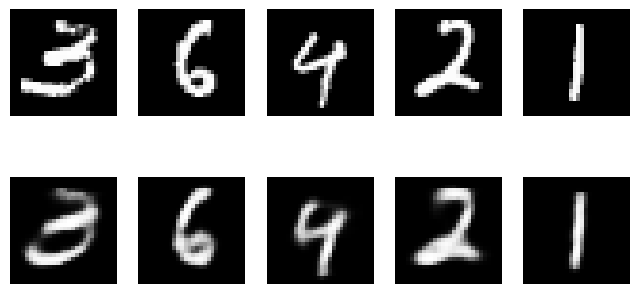

In [8]:
images, _ = next(iter(train_loader))
images_flat = images.view(images.size(0), -1)

recon_images, _, _ = model(images_flat)

images = images.numpy()
recon_images = recon_images.detach().numpy()

plt.figure(figsize=(8,4))

for i in range(5):

    plt.subplot(2,5,i+1)
    plt.imshow(images[i][0], cmap='gray')
    plt.axis('off')

    plt.subplot(2,5,i+6)
    plt.imshow(recon_images[i].reshape(28,28), cmap='gray')
    plt.axis('off')

plt.show()


Full Implementation

In [9]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [10]:
transform = transforms.ToTensor()

train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=128,
    shuffle=True
)


In [11]:
class CNNVAE(nn.Module):
    def __init__(self, latent_dim=64):
        super(CNNVAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(64*7*7, latent_dim)
        self.fc_logvar = nn.Linear(64*7*7, latent_dim)

        # Decoder
        self.fc_decode = nn.Linear(latent_dim, 64*7*7)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):

        x = self.encoder(x)
        x = x.view(x.size(0), -1)

        mu = self.fc_mu(x)
        log_var = self.fc_logvar(x)

        z = self.reparameterize(mu, log_var)

        x = self.fc_decode(z)
        x = x.view(x.size(0), 64, 7, 7)

        x = self.decoder(x)

        return x, mu, log_var


In [12]:
def loss_function(recon_x, x, mu, log_var):

    recon_loss = nn.functional.binary_cross_entropy(
        recon_x, x, reduction='sum'
    )

    kl_loss = -0.5 * torch.sum(
        1 + log_var - mu.pow(2) - log_var.exp()
    )

    return recon_loss + kl_loss


In [13]:
model = CNNVAE()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 15

for epoch in range(epochs):
    total_loss = 0

    for images, _ in train_loader:

        recon_images, mu, log_var = model(images)

        loss = loss_function(recon_images, images, mu, log_var)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader.dataset):.4f}")


Epoch [1/15], Loss: 157.3183
Epoch [2/15], Loss: 114.7821
Epoch [3/15], Loss: 109.7049
Epoch [4/15], Loss: 107.5902
Epoch [5/15], Loss: 106.3771
Epoch [6/15], Loss: 105.6175
Epoch [7/15], Loss: 105.0761
Epoch [8/15], Loss: 104.5578
Epoch [9/15], Loss: 104.1784
Epoch [10/15], Loss: 103.8403
Epoch [11/15], Loss: 103.5147
Epoch [12/15], Loss: 103.2551
Epoch [13/15], Loss: 103.0151
Epoch [14/15], Loss: 102.7457
Epoch [15/15], Loss: 102.5739


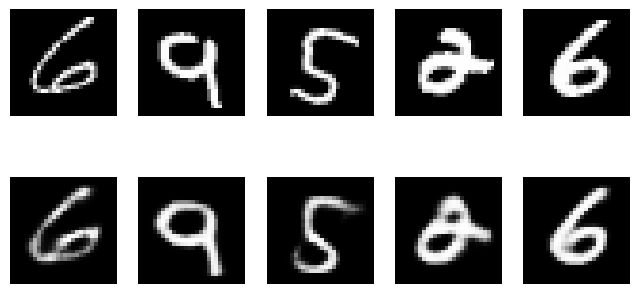

In [14]:
images, _ = next(iter(train_loader))
recon_images, _, _ = model(images)

images = images.numpy()
recon_images = recon_images.detach().numpy()

plt.figure(figsize=(8,4))

for i in range(5):

    plt.subplot(2,5,i+1)
    plt.imshow(images[i][0], cmap='gray')
    plt.axis('off')

    plt.subplot(2,5,i+6)
    plt.imshow(recon_images[i][0], cmap='gray')
    plt.axis('off')

plt.show()
